C:\Users\KIIT\AppData\Local\Temp\ipykernel_25548\2899583996.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Dynamically map colors


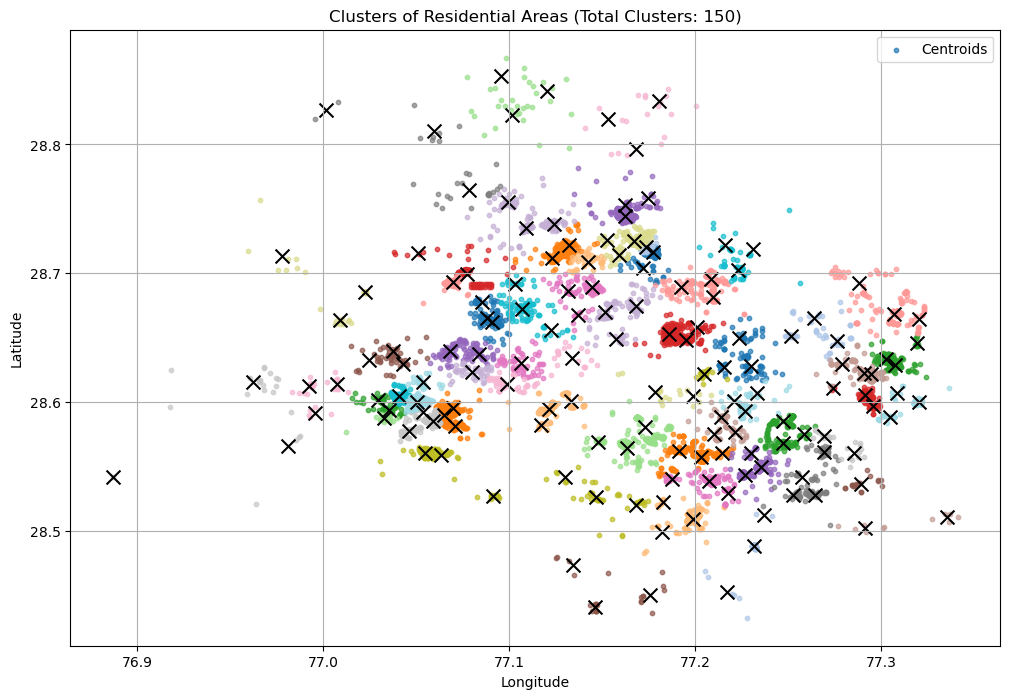

In [2]:
# Set environment variables FIRST to prevent memory leaks
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Crucial for Windows/MKL users
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import haversine_distances

# Load dataset
data = pd.read_csv('delhi_residential_coordinates.csv')

# Extract latitude and longitude
coordinates = data[['latitude', 'longitude']].values

# Remove duplicate points
unique_coordinates = np.unique(coordinates, axis=0)

# Function to calculate Haversine distance (in km)
def haversine_distance_km(coord1, coord2):
    return haversine_distances([coord1], [coord2])[0][0] * 6371  # Earth's radius in km

def cluster_and_divide(coordinates, n_clusters=50, min_cluster_size=15, subcluster_radius=10):
    """
    Clusters geographical coordinates using K-Means and divides large clusters if needed.

    Parameters:
    - coordinates: numpy array of shape (n, 2) with latitude and longitude values.
    - n_clusters: Initial number of clusters.
    - min_cluster_size: Minimum size for a cluster to be considered valid.
    - subcluster_radius: Maximum radius (in km) before a cluster is divided further.

    Returns:
    - final_labels: Cluster labels for each coordinate.
    - new_centroids: Array of cluster centroids.
    """

    n_samples = coordinates.shape[0]
    n_clusters = min(n_clusters, n_samples)  # Ensure clusters don't exceed data points

    # Perform initial K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto', init='k-means++')
    labels = kmeans.fit_predict(coordinates)
    centroids = kmeans.cluster_centers_

    # Organize points into clusters
    cluster_members = {i: coordinates[labels == i] for i in range(n_clusters)}

    # Initialize final labels and new centroids
    final_labels = np.full(n_samples, -1)  # -1 for unassigned
    new_centroids = []

    # Process each cluster
    new_cluster_id = 0  # Track new cluster indices
    for cluster_id, points in cluster_members.items():
        if len(points) < min_cluster_size:
            continue  # Skip small clusters

        current_centroid = centroids[cluster_id]

        # Calculate max Haversine distance from centroid
        distances = np.array([haversine_distance_km(current_centroid, p) for p in points])
        max_distance_km = np.max(distances) if len(distances) > 0 else 0

        if max_distance_km > subcluster_radius:
            # Limit excessive subclusters
            num_subclusters = min(len(points), max(2, min(3, int(np.ceil(max_distance_km / subcluster_radius)))))

            try:
                sub_kmeans = KMeans(n_clusters=num_subclusters, random_state=0, n_init='auto', init='k-means++')
                sub_labels = sub_kmeans.fit_predict(points)
                sub_centroids = sub_kmeans.cluster_centers_

                for sub_label, sub_centroid in enumerate(sub_centroids):
                    new_centroids.append(sub_centroid)

                    # Ensure correct assignment of labels
                    sub_indices = np.where(labels == cluster_id)[0]
                    final_labels[sub_indices[sub_labels == sub_label]] = new_cluster_id
                    new_cluster_id += 1

            except ValueError as e:
                print(f"Sub-clustering failed for cluster {cluster_id}: {e}")
                continue
        else:
            # Assign all points to this cluster
            cluster_indices = np.where(labels == cluster_id)[0]
            final_labels[cluster_indices] = new_cluster_id
            new_centroids.append(current_centroid)
            new_cluster_id += 1

    return final_labels, np.array(new_centroids)


# Perform clustering and division
n_clusters = 50  # Initial number of clusters
labels, centroids = cluster_and_divide(unique_coordinates, n_clusters=n_clusters)

# Ensure centroids are in the correct shape
if centroids.ndim == 1:
    centroids = centroids.reshape(-1, 2)

# Plot results
plt.figure(figsize=(12, 8))
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Dynamically map colors

for i, label in enumerate(unique_labels):
    if label != -1:  # Only plot assigned labels
        cluster_points = unique_coordinates[labels == label]
        plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=10, color=colors(i), alpha=0.7)

# Plot centroids (only if they exist)
if centroids.size > 0:
    plt.scatter(centroids[:, 1], centroids[:, 0], c='black', marker='x', s=100, label='Centroids')

# Display the number of clusters in the title
num_clusters = len(unique_labels[unique_labels != -1])  # Exclude -1 (unassigned points)
plt.title(f'Clusters of Residential Areas (Total Clusters: {num_clusters})')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(["Centroids"])  # Only legend for centroids
plt.grid(True)
plt.show()


C:\Users\KIIT\AppData\Local\Temp\ipykernel_25548\3246955585.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Dynamically map colors


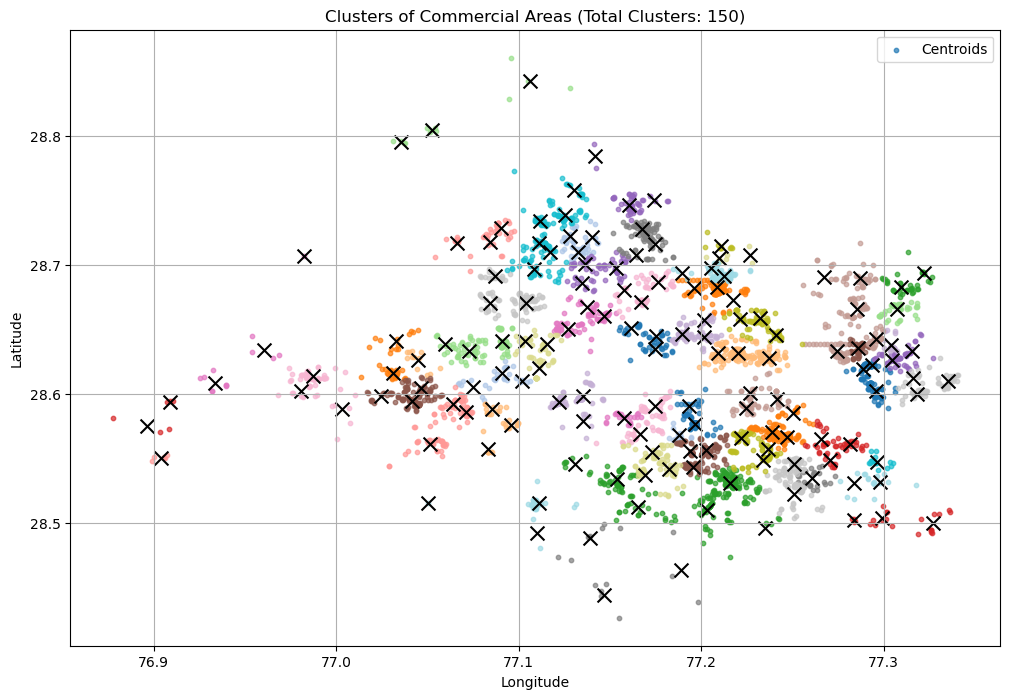

In [3]:
# Set environment variables FIRST to prevent memory leaks
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Crucial for Windows/MKL users
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import haversine_distances

# Load dataset
data = pd.read_csv('delhi_shopping_coordinates.csv')

# Extract latitude and longitude
coordinates = data[['latitude', 'longitude']].values.astype(float)

# Remove duplicate points
unique_coordinates = np.unique(coordinates, axis=0)

# Function to calculate Haversine distance (in km)
def haversine_distance_km(coord1, coord2):
    return haversine_distances([coord1], [coord2])[0][0] * 6371  # Earth's radius in km

def cluster_and_divide(coordinates, n_clusters=50, min_cluster_size=10, subcluster_radius=20):
    """
    Clusters geographical coordinates using K-Means and divides large clusters if needed.

    Parameters:
    - coordinates: numpy array of shape (n, 2) with latitude and longitude values.
    - n_clusters: Initial number of clusters.
    - min_cluster_size: Minimum size for a cluster to be considered valid.
    - subcluster_radius: Maximum radius (in km) before a cluster is divided further.

    Returns:
    - final_labels: Cluster labels for each coordinate.
    - new_centroids: Array of cluster centroids.
    """

    n_samples = coordinates.shape[0]
    n_clusters = min(n_clusters, n_samples)  # Ensure clusters don't exceed data points

    # Perform initial K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto', init='k-means++')
    labels = kmeans.fit_predict(coordinates)
    centroids = kmeans.cluster_centers_

    # Organize points into clusters
    cluster_members = {i: coordinates[labels == i] for i in range(n_clusters)}

    # Initialize final labels and new centroids
    final_labels = np.full(n_samples, -1)  # -1 for unassigned
    new_centroids = []

    # Process each cluster
    new_cluster_id = 0  # Track new cluster indices
    for cluster_id, points in cluster_members.items():
        if len(points) < min_cluster_size:
            continue  # Skip small clusters

        current_centroid = centroids[cluster_id]

        # Calculate max Haversine distance from centroid
        distances = np.array([haversine_distance_km(current_centroid, p) for p in points])
        max_distance_km = np.max(distances) if len(distances) > 0 else 0

        if max_distance_km > subcluster_radius:
            # Limit excessive subclusters
            num_subclusters = min(len(points), max(2, min(3, int(np.ceil(max_distance_km / subcluster_radius)))))

            try:
                sub_kmeans = KMeans(n_clusters=num_subclusters, random_state=0, n_init='auto', init='k-means++')
                sub_labels = sub_kmeans.fit_predict(points)
                sub_centroids = sub_kmeans.cluster_centers_

                for sub_label, sub_centroid in enumerate(sub_centroids):
                    new_centroids.append(sub_centroid)

                    # Ensure correct assignment of labels
                    sub_indices = np.where(labels == cluster_id)[0]
                    final_labels[sub_indices[sub_labels == sub_label]] = new_cluster_id
                    new_cluster_id += 1

            except ValueError as e:
                print(f"Sub-clustering failed for cluster {cluster_id}: {e}")
                continue
        else:
            # Assign all points to this cluster
            cluster_indices = np.where(labels == cluster_id)[0]
            final_labels[cluster_indices] = new_cluster_id
            new_centroids.append(current_centroid)
            new_cluster_id += 1

    return final_labels, np.array(new_centroids)


# Perform clustering and division
n_clusters = 50  # Initial number of clusters
labels, centroids = cluster_and_divide(unique_coordinates, n_clusters=n_clusters)

# Ensure centroids are in the correct shape
if centroids.ndim == 1:
    centroids = centroids.reshape(-1, 2)

# Plot results
plt.figure(figsize=(12, 8))
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap("tab20", len(unique_labels))  # Dynamically map colors

for i, label in enumerate(unique_labels):
    if label != -1:  # Only plot assigned labels
        cluster_points = unique_coordinates[labels == label]
        plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=10, color=colors(i), alpha=0.7)

# Plot centroids (only if they exist)
if centroids.size > 0:
    plt.scatter(centroids[:, 1], centroids[:, 0], c='black', marker='x', s=100, label='Centroids')

# Display the number of clusters in the title
num_clusters = len(unique_labels[unique_labels != -1])  # Exclude -1 (unassigned points)
plt.title(f'Clusters of Commercial Areas (Total Clusters: {num_clusters})')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(["Centroids"])  # Only legend for centroids
plt.grid(True)
plt.show()
